# Отток в телекоме

Требуется спрогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

 ## 1. Предобработка данных

### 1.1 Импорты

In [114]:
#pip install -U scikit-learn

In [115]:
#pip install catboost

In [116]:
#pip install numpy --upgrade

In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics


from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import feature_selection
from sklearn.model_selection import StratifiedKFold

### 1.2 Загрузка данных

In [118]:
data_contract = pd.read_csv('contract.csv')
data_internet = pd.read_csv('internet.csv')
data_personal = pd.read_csv('personal.csv')
data_phone = pd.read_csv('phone.csv')

### 1.3 Первичный осмотр данных

#### Контракты

Посмотрим на таблицу с контрактами

In [119]:
data_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [120]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [121]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [122]:
data_contract['customerID'].unique().size

7043

Видим, что:
   1. Каждый контракт заключен с уникальным пользователем
   2. Есть информация про 7043 пользователя
   2. Столбец TotalCharges имеет тип данных  object
   
Переведем данные столбца TotalCharges в числовой тип

In [123]:
data_contract['TotalCharges'] = pd.to_numeric(data_contract['TotalCharges'],errors = 'coerce')

In [124]:
data_contract[data_contract.isnull().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [125]:
data_contract = data_contract.dropna(axis=0, how='any')

In [126]:
data_contract[data_contract['BeginDate']=='2020-02-01']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


При изменении типа данных проблемы возникли с контратками, заключенными 2020-02-01. Так как такие контракты с точки зрения решения задачи не добавляют нам информации разумно будет их просто удалить

#### Интернет

Посмотрим на таблицу с пользователями интернета

In [127]:
data_internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [128]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [129]:
data_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4369-NYSCF,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


1. Пропусков в данных нет
2. Каждая строчка это описание услуг для уникального пользователя
3. Интернет используют 5517 человек

#### Телефонная связь

Посмотрим на таблицу с пользователями телефонной связи

In [130]:
data_phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [131]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [132]:
data_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,7850-VWJUU,No
freq,1,3390


1. Пропусков в данных нет
2. Каждая строчка это описание услуг для уникального пользователя
3. Интернет используют 6361 человек

#### Персональные данные

Посмотрим на персональные данные

In [133]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [134]:
data_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [135]:
data_personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [136]:
data_personal['customerID'].unique().size

7043

1. Персональные данные приводтся для кадлонор пользователя, имеюшего контракт
2. Пропусков в данных нет

### 1.4 Создание единого датафрейма

Объединим все данные в одну таблицу по столбцу customerID

In [137]:
data_all = data_contract.merge(data_internet,how='left', on='customerID').merge(
    data_phone, how='left', on='customerID').merge(
    data_personal, how='left', on='customerID')

In [138]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
 8   InternetService   5512 non-null   object 
 9   OnlineSecurity    5512 non-null   object 
 10  OnlineBackup      5512 non-null   object 
 11  DeviceProtection  5512 non-null   object 
 12  TechSupport       5512 non-null   object 
 13  StreamingTV       5512 non-null   object 
 14  StreamingMovies   5512 non-null   object 
 15  MultipleLines     6352 non-null   object 
 16  gender            7032 non-null   object 


В объединенной таблице появились порпуски, так как в таблицах data_internet и data_phone отличается количество пользователей

In [139]:
internet_features = data_internet.drop(['customerID'], axis=1).columns
phone_features = data_phone.drop(['customerID'], axis=1).columns

In [140]:
data_all[internet_features] =  data_all[internet_features].fillna('no_internet')
data_all[phone_features] =  data_all[phone_features].fillna('no_phone')

Заполняем пропуски исходя из следующей логики:
1. Для пользователей, не встречающихся в таблице internet_features, заполняем соотв. поля значением "no_internet"
1. Для пользователей, не встречающихся в таблице phone_features, заполняем соотв. поля значением "no_phone"

In [141]:
data_all

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,no_phone,Female,0,Yes,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,no_phone,Male,0,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,Male,0,Yes,Yes
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,Female,0,Yes,Yes
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,no_phone,Female,0,Yes,Yes
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes,Male,1,Yes,No


### 1.5 Выделение целевого признака. Разбиение датасета на train и test

Отточниками считаем клиентов, у которых в столбце EndDate стоит дата. Если в этом столбце указано значение "No" - то значит клиент продолжает пользоваться услугами компании

In [142]:
def target(x):
  if x == 'No':
    return 0
  else:
    return 1

In [143]:
data_all['Target'] = data_all['EndDate'].apply(target)

In [144]:
data_all['Target'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Target, dtype: float64

Переводим данные в столбцах EndDate и BeginDate в формат datatime64. Для клиентов, которые на текущий день (01.02.2020) не ушли из компании в столбце EndDate проставляем '2020-02-01 00:00:00'

In [145]:
data_all['BeginDate'] = pd.to_datetime(data_all['BeginDate'], format='%Y-%m-%d')
data_all['EndDate'] = data_all['EndDate'].replace('No', '2020-02-01 00:00:00')
data_all['EndDate'] = pd.to_datetime(data_all['EndDate'], format='%Y-%m-%d %H:%M:%S')

Выделяем таблицу признаков и отдельно целевой признак

In [146]:
X = data_all.drop(['customerID','Target'], axis =1)
y = data_all['Target']

 Разделяем датасет на тренировочную и тестовую части

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 2. Анализ данных

### 2.1 Визуализация данных и поиск взаимосвязей

Проведем анализ данных. Определим взаимосвязи между признаками и целевым признаком

In [148]:
telecom = X_train.join(y_train)
telecom

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,Target
1408,2014-09-01,2020-02-01,Two year,No,Credit card (automatic),94.55,6078.75,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes,Male,0,Yes,Yes,0
6992,2017-12-01,2020-02-01,Month-to-month,No,Electronic check,35.75,1022.50,DSL,No,No,Yes,Yes,No,No,no_phone,Male,0,No,No,0
3349,2014-06-01,2020-02-01,Two year,No,Credit card (automatic),90.20,6297.65,Fiber optic,No,Yes,Yes,Yes,No,No,Yes,Female,0,Yes,No,0
4486,2019-11-01,2020-02-01,Month-to-month,No,Electronic check,84.30,235.05,Fiber optic,No,Yes,No,No,No,Yes,No,Male,0,No,No,0
3535,2016-01-01,2020-02-01,Month-to-month,No,Bank transfer (automatic),40.65,2070.75,DSL,Yes,No,No,No,Yes,No,no_phone,Female,0,Yes,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3445,2014-09-01,2020-02-01,One year,Yes,Bank transfer (automatic),70.95,4555.20,Fiber optic,No,No,No,No,No,No,No,Male,1,Yes,No,0
5115,2018-09-01,2019-12-01,Month-to-month,Yes,Credit card (automatic),75.30,1147.45,Fiber optic,No,Yes,No,No,No,No,No,Female,1,No,No,1
4128,2017-02-01,2020-02-01,Two year,Yes,Credit card (automatic),92.90,3379.25,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Female,0,Yes,Yes,0
4242,2019-04-01,2020-02-01,One year,Yes,Mailed check,65.90,660.05,DSL,No,Yes,Yes,No,No,Yes,No,Female,0,Yes,Yes,0


Для удобства дальнейшего анализа добавим признаки 'Is_Internet' и 'Is_Phone', показывающие пользуется ли клиент услугами интернета или телефона соответственно

In [149]:
telecom['Is_Internet'] = (telecom['OnlineSecurity'] !='no_internet')*1
telecom['Is_Phone'] = (telecom['MultipleLines'] !='no_phone')*1

Так как одним из признаков является дата заключения контракта, посмотрим есть ли тренд год от года по количеству заключенных контрактов и вероятности оттока

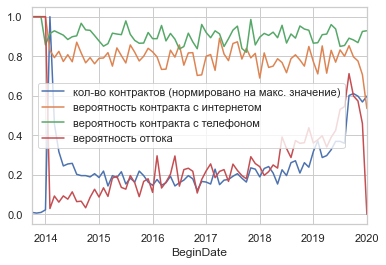

In [150]:
(telecom.groupby('BeginDate')['Target'].count()/np.max(telecom.groupby('BeginDate')['Target'].count())).plot(
    label='кол-во контрактов (нормировано на макс. значение)')
telecom.groupby('BeginDate')['Is_Internet'].mean().plot(label='вероятность контракта с интернетом')
telecom.groupby('BeginDate')['Is_Phone'].mean().plot(label='вероятность контракта с телефоном')
telecom.groupby('BeginDate')['Target'].mean().plot(label='вероятность оттока')
plt.legend()

Отмечаем:
1. Вероятность того, что контракт будет включать в себя использование телефона или интернета год от года не изменяется
2. Кол-во заключенных контрактов с 2015 по 2018 практически не изменяется. Дальше начинается резкий рост
3. Отток клиентов практически равномерно растет для заключивших контракт начиная с 2015 года, для заключивших после 2019 начинается более крутой рост

Получается что любой признак, учитывающий момент заключения контракта, будет хорошо работать для прогнозирования оттока

In [151]:
telecom.groupby(['Is_Internet','Is_Phone'])['Target'].agg(['count','mean'])

count      mean
Is_Internet Is_Phone                 
0           1          1208  0.073675
1           0           545  0.253211
            1          3872  0.327479

Кроме того, практически нулевым оттоком характеризуются клиенты, использующие только услуги телефонии

Таким образом, наиболее сложной будет классификации клиентов внутри группы "есть интернет"

#### Количественные признаки

 Более предметно посмотрим на каждый из количественных признаков

##### MonthlyCharges

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

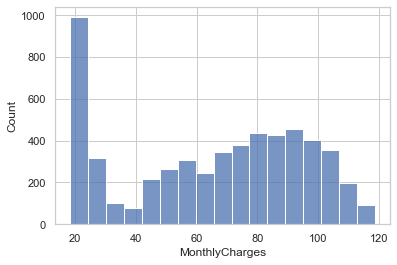

In [152]:
sns.histplot(telecom["MonthlyCharges"])

Распределение данного признака имеет два максимума: 
1. Первый  в окрестности 20 (по всей видимости это клиенты, использующие только телефон)
2. Второй в окрестности 90 (клиенты использующие интернет)

Проверим эти предположения

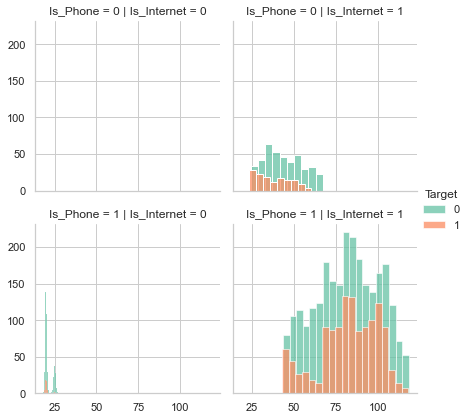

In [153]:
g = sns.FacetGrid(telecom, col="Is_Internet", row='Is_Phone', palette='Set2', hue='Target')
g.map_dataframe(sns.histplot, x="MonthlyCharges")
g.add_legend()

И если для всех данных среднее значение MonthlyCharges заметно отличается, то при сравнении среднего значения этого признака внутри отдельных групп пользователей (есть интернет/нет интернета) разницы практически нет

In [154]:
telecom.groupby(['Target'])['MonthlyCharges'].agg(['count','mean'])

,count,mean
Target,,
0,4130,61.495194
1,1495,74.679599


In [155]:
telecom.groupby(['Is_Internet', 'Target'])['MonthlyCharges'].agg(['count','mean'])

count       mean
Is_Internet Target                  
0           0        1119  21.117828
            1          89  20.489326
1           0        3011  76.500930
            1        1406  78.109851

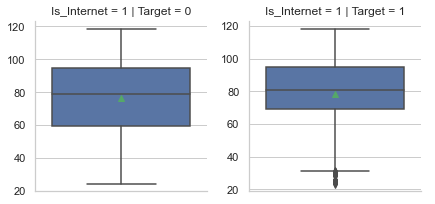

In [156]:
g = sns.FacetGrid(telecom[telecom['Is_Internet']==1], col="Target", row='Is_Internet', palette='Set2', sharey=False)#, hue='Target')
g.map_dataframe(sns.boxplot, y="MonthlyCharges", showmeans=True)
g.add_legend()

In [157]:
telecom['MonthlyCharges_q'] = pd.qcut(telecom[telecom['Is_Internet']==1]['MonthlyCharges'],10)

In [158]:
t = telecom.groupby('MonthlyCharges_q')[['Target']].agg(['count','mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,Target_count,Target_mean
MonthlyCharges_q,,
"(23.448999999999998, 45.45]",443,0.331828
"(45.45, 55.01]",441,0.276644
"(55.01, 65.6]",442,0.131222
"(65.6, 74.05]",442,0.332579
"(74.05, 79.6]",441,0.380952
"(79.6, 84.98]",441,0.353741
"(84.98, 90.8]",445,0.359551
"(90.8, 98.1]",439,0.398633
"(98.1, 104.6]",443,0.397291


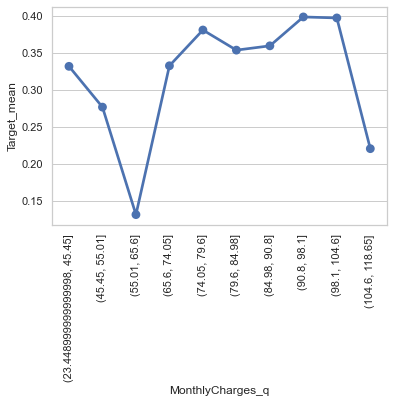

In [159]:
sns.pointplot(data = t, x=t.index, y='Target_mean')
degrees = 90
plt.xticks( rotation = degrees)
plt.show()

Исходя из проведенного анализа становится понятно, что классификации пользователей внутри группы "есть интернет" признак MonthlyCharges не поможет

##### TotalCharges

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

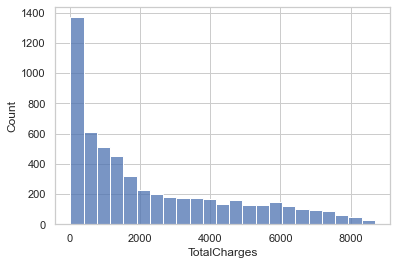

In [160]:
sns.histplot(telecom["TotalCharges"])

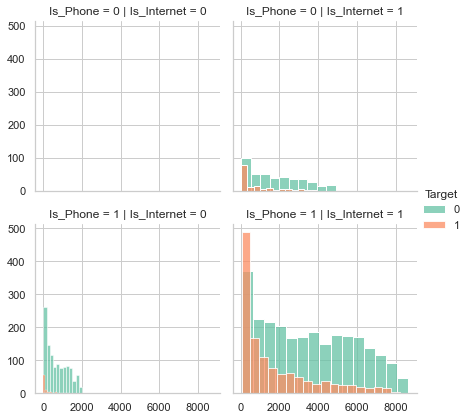

In [161]:
g = sns.FacetGrid(telecom, col="Is_Internet", row='Is_Phone', palette='Set2', hue='Target')
g.map_dataframe(sns.histplot, x="TotalCharges")
g.add_legend()

In [162]:
telecom.groupby(['Is_Internet', 'Target'])['TotalCharges'].agg(['count','mean'])

count         mean
Is_Internet Target                    
0           0        1119   703.913628
            1          89   196.647753
1           0        3011  3267.461159
            1        1406  1638.933677

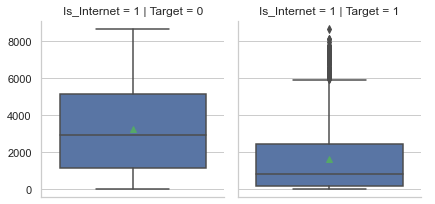

In [163]:
g = sns.FacetGrid(telecom[telecom['Is_Internet']==1], col="Target", row='Is_Internet', palette='Set2')#, hue='Target')
g.map_dataframe(sns.boxplot, y="TotalCharges", showmeans=True)
g.add_legend()

In [164]:
telecom['TotalCharges_q'] = pd.qcut(telecom[telecom['Is_Internet']==1]['TotalCharges'],10)

In [165]:
t = telecom.groupby('TotalCharges_q')[['Target']].agg(['count','mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,Target_count,Target_mean
TotalCharges_q,,
"(23.448999999999998, 119.1]",442,0.690045
"(119.1, 415.7]",442,0.513575
"(415.7, 851.38]",441,0.421769
"(851.38, 1418.42]",442,0.371041
"(1418.42, 2178.6]",442,0.273756
"(2178.6, 3020.66]",441,0.272109
"(3020.66, 3994.13]",442,0.178733
"(3994.13, 5101.71]",441,0.185941
"(5101.71, 6378.73]",442,0.153846


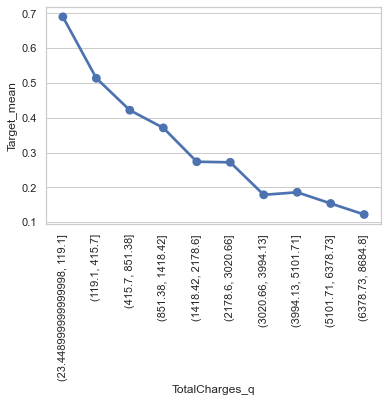

In [166]:
sns.pointplot(data = t, x=t.index, y='Target_mean')
degrees = 90
plt.xticks( rotation = degrees)
plt.show()

Отмечаем, что в отличие от MonthlyCharges признак TotalCharges гораздо лучше разделяет пользователей внутри группы "есть интернет". По всей видимости это связано с тем, что он косвенно учитывает дату начала контракта

#####   Взаимосвязь между признаками

In [167]:
telecom[['MonthlyCharges', 'TotalCharges']].corr()

,MonthlyCharges,TotalCharges
MonthlyCharges,1.000000,0.652554
TotalCharges,0.652554,1.000000


In [168]:
telecom['BeginYear'] = pd.DatetimeIndex(telecom['BeginDate']).year
telecom['BeginMonth'] = pd.DatetimeIndex(telecom['BeginDate']).month

<AxesSubplot:xlabel='MonthlyCharges', ylabel='TotalCharges'>

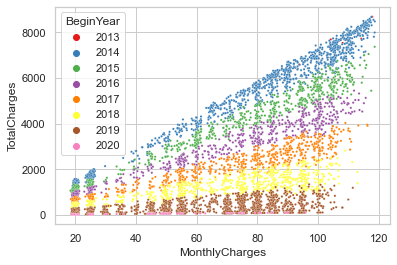

In [169]:
sns.scatterplot(x="MonthlyCharges", y="TotalCharges", data=telecom.sort_values(
    by='BeginYear'), s=5, hue='BeginYear', palette = 'Set1')

In [170]:
t =telecom.groupby('BeginYear')[['MonthlyCharges', 'TotalCharges']].corr().reset_index(
    level=[0,1]).set_index('BeginYear')

In [171]:
t[t['level_1']=='MonthlyCharges'][['level_1', 'TotalCharges']]

,level_1,TotalCharges
BeginYear,,
2013,MonthlyCharges,0.980256
2014,MonthlyCharges,0.990391
2015,MonthlyCharges,0.984818
2016,MonthlyCharges,0.978368
2017,MonthlyCharges,0.953840
2018,MonthlyCharges,0.868886
2019,MonthlyCharges,0.514930
2020,MonthlyCharges,1.000000


Признаки MonthlyCharges	и TotalCharges оказываются сильно скоррелированными. Особенно это становится заметно, если при расчете коэфициента корреляции учесть год заключения контракта

#### Категориальные признаки

Более предметно посмотрим на каждый из категориальных признаков

##### Type, PaperlessBilling, PaymentMethod, gender

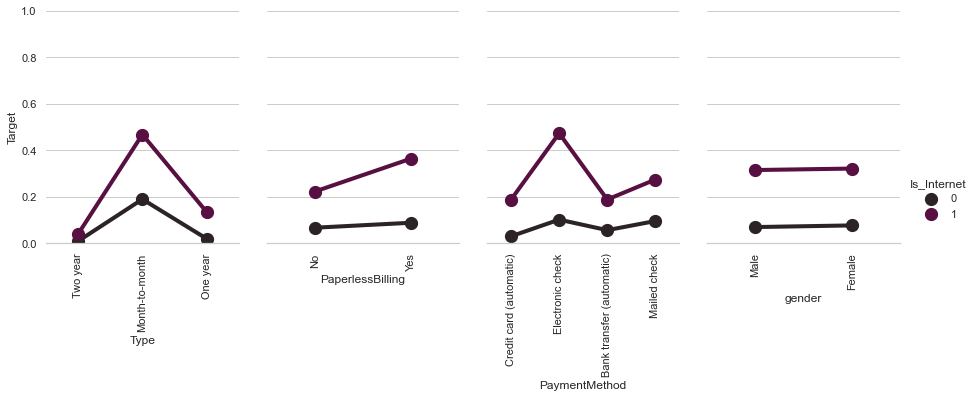

In [172]:
sns.set_theme(style="whitegrid")

g = sns.PairGrid(telecom, y_vars="Target",
                 x_vars=['Type','PaperlessBilling','PaymentMethod', 'gender'],
                 height=4, aspect=0.8, hue='Is_Internet')

g.map(sns.pointplot, scale=1.5, errwidth=0, color="xkcd:plum")
g.add_legend()

for ax in g.axes.flatten():
    # rotate x axis labels
    ax.tick_params(axis='x', rotation=90)

degrees = 90
plt.xticks( rotation = degrees)
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)


Для группы клиентов "есть интернет" важными признаками оказываются  Type (тип контракта), PaymentMethod (способ оплаты), PaperlessBilling:
1. Двухлетний и однолетний контракт характеризуются существенно меньшим оттоком
2. При оплате электронным чеком вероятность оттока практически в два раза выше

##### InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV,	StreamingMovies

Посмотрим как влияют на отток дополнительные услуги у пользователей с интернетом

In [173]:
telecom = telecom.replace(['Yes', 'No', 'no_internet'],[1, 0, 100])

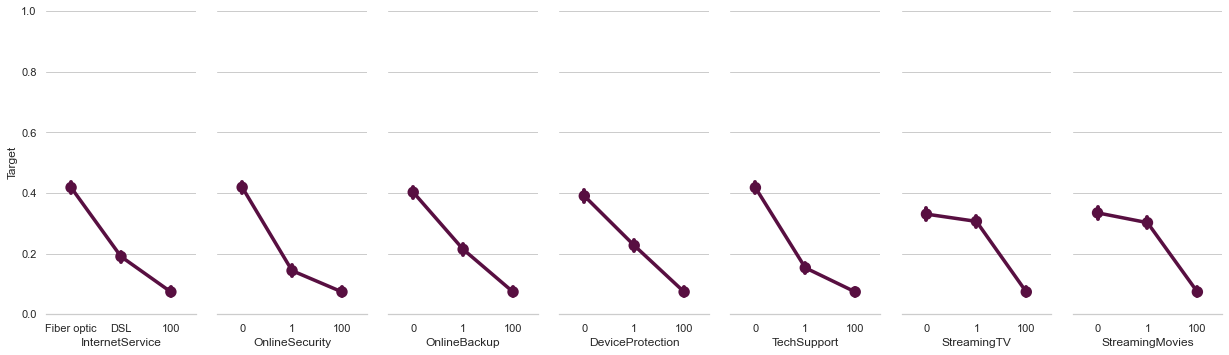

In [174]:
sns.set_theme(style="whitegrid")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(telecom, y_vars="Target",
                 x_vars=['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',	'StreamingMovies'],
                 height=5, aspect=.5)

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
g.set(ylim=(0, 1))
sns.despine(fig=g.fig, left=True)

1. Наличие дополнительных услуг OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport снижает вероятность оттока
2. Наличие оптоволокнового соединения наоборот вероятность оттока увеличивает
3. Сервисы StreamingTV и StreamingMovies на отток не влияют

In [175]:
telecom_only_internet = telecom[telecom['InternetService']!=100]

<AxesSubplot:xlabel='StreamingTV', ylabel='StreamingMovies'>

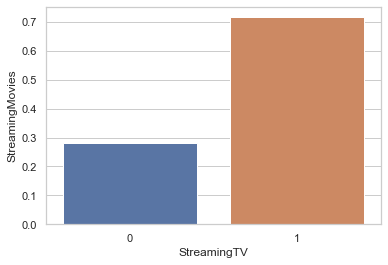

In [176]:
gr3 = telecom_only_internet.groupby('StreamingTV')[['StreamingMovies']].mean()
sns.barplot(x = gr3.index, y= 'StreamingMovies', data = gr3)

Сервисы StreamingTV и StreamingMovies оказываются сильно связанными между собой: наличие одного подключенного сервиса с большой вероятностью означает и подключение другого

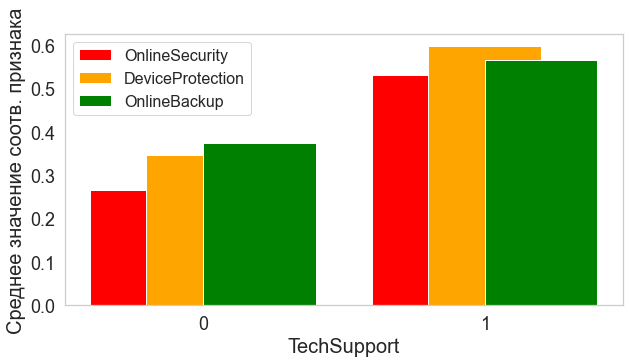

In [177]:
gr1= telecom_only_internet.groupby('TechSupport')[['OnlineSecurity', 'DeviceProtection', 'OnlineBackup']].mean()
X_l = gr1.index
X_axis = np.arange(len(X_l))

figure_name = plt.figure(figsize=(10, 5))

color_dict = {'OnlineSecurity':'red', 'DeviceProtection': 'orange', 'OnlineBackup':'green'}

for i in range(len(gr1.columns)):
    plt.bar(X_axis + (-0.2 +i*0.2), gr1[gr1.columns[i]], 0.4, label = gr1.columns[i], color = color_dict[gr1.columns[i]])

plt.xticks(X_axis, X_l)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.xlabel('TechSupport', fontsize = 20)
plt.ylabel("Среднее значение соотв. признака", fontsize = 20)
plt.legend(fontsize = 16)
plt.grid()
plt.show()


То же самое можно сказать про сервисы OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport

##### SeniorCitizen, Partner,	Dependents

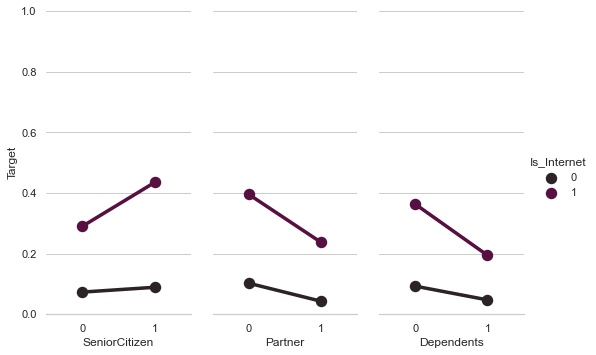

In [178]:
sns.set_theme(style="whitegrid")

# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(telecom, y_vars="Target",
                 x_vars=['SeniorCitizen',	'Partner',	'Dependents'],
                 height=5, aspect=.5, hue='Is_Internet')

# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=0, color="xkcd:plum")
g.set(ylim=(0, 1))
g.add_legend()
sns.despine(fig=g.fig, left=True)


Для обеих групп -  "есть интернет" и "нет интернета" - ситация схожа, однако, при наличии интернета зависимости оказываются более выраженными:
1. В случае если клиент пенсионер вероятность оттока выше
2. Если у клиента есть партнер или дети вероятность оттока ниже

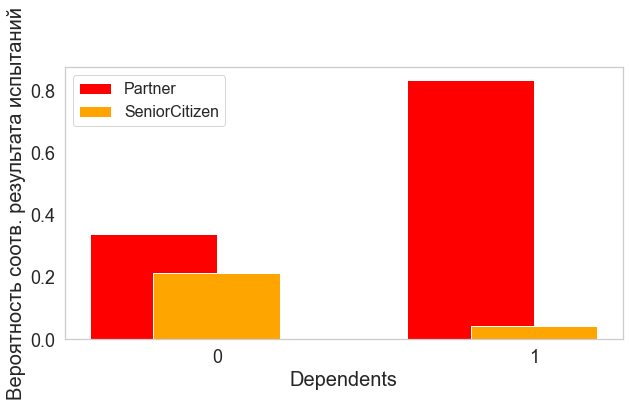

In [179]:
gr2 = telecom.groupby('Dependents')[['Partner','SeniorCitizen']].mean()
X_l = gr2.index
X_axis = np.arange(len(X_l))

figure_name = plt.figure(figsize=(10, 5))

color_dict = {'Partner':'red', 'SeniorCitizen': 'orange'}

for i in range(len(gr2.columns)):
  plt.bar(X_axis + (-0.2 +i*0.2), gr2[gr2.columns[i]], 0.4, label = gr2.columns[i], color = color_dict[gr2.columns[i]])
  
plt.xticks(X_axis, X_l)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.xlabel("Dependents", fontsize = 20)
plt.ylabel("Вероятность соотв. результата испытаний", fontsize = 20)
plt.legend(fontsize = 16)
plt.grid()
plt.show()


Признаки Partner и Dependents оказываются сильно скорелиррованными

### 2.2 Экспериментирование с комбинациями признаков

Проведенный выше анализ показал, что признаки, учитывающие дату заключения контракта, существенно влияют на Target. Создадим новый признак - ClientLifetime -  определяемый как разность EndDate и BeginDate, в двух версиях:
1. Измеряемый в днях ClientLifetime_D
2. Измеряемый в месяцах ClientLifetime_M

#### ClientLifetime

In [180]:
telecom['ClientLifetime_D'] = round((telecom['EndDate'] - telecom['BeginDate'])/np.timedelta64(1,'D'),1)
telecom['ClientLifetime_M'] = round((telecom['EndDate'] - telecom['BeginDate'])/np.timedelta64(1,'M'),1)

In [181]:
pd.DatetimeIndex(telecom['BeginDate']).day.value_counts()

1    5625
Name: BeginDate, dtype: int64

<AxesSubplot:xlabel='ClientLifetime_M', ylabel='Count'>

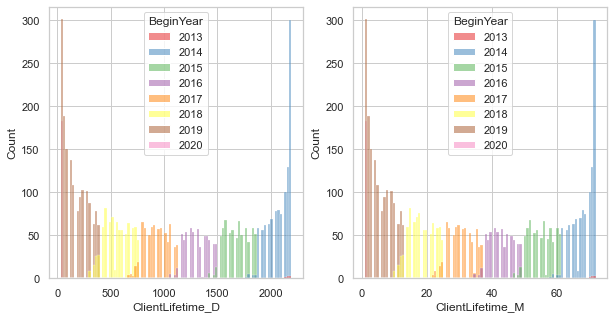

In [182]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
sns.histplot(data = telecom, x='ClientLifetime_D', bins = 100, hue='BeginYear', palette = 'Set1', ax=axs[0])
sns.histplot(data = telecom, x='ClientLifetime_M', bins = 100, hue='BeginYear', palette = 'Set1', ax=axs[1])

In [183]:
telecom.query('ClientLifetime_M<=10').groupby(['ClientLifetime_M','ClientLifetime_D'])['Target'].agg(['count','mean'])

count      mean
ClientLifetime_M ClientLifetime_D                 
1.0              30.0                147  1.000000
                 31.0                337  0.456973
2.0              61.0                 95  1.000000
                 62.0                 94  0.000000
3.0              91.0                 24  1.000000
                 92.0                126  0.380952
4.0              122.0                43  1.000000
                 123.0                95  0.210526
5.0              153.0               109  0.513761
6.0              183.0                11  1.000000
                 184.0                67  0.253731
7.0              214.0                41  1.000000
7.1              215.0                53  0.000000
8.0              242.0                12  1.000000
                 244.0                 8  1.000000
                 245.0                83  0.216867
9.0              273.0                28  1.000000
                 275.0                12  1.000000
9.1              276.0                61  0.000000
10.0             303.0                 7  1.000000
                 304.0                22  1.000000

ClientLifetime_D показывает лучшую разрешающую способность, поэтому дальше продолжаем работать только с ним

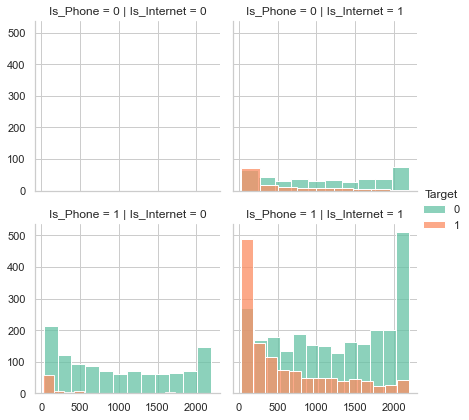

In [184]:
g = sns.FacetGrid(telecom, col="Is_Internet", row='Is_Phone', palette='Set2', hue='Target')
g.map_dataframe(sns.histplot, x="ClientLifetime_D")
g.add_legend()

In [185]:
telecom.groupby(['Is_Internet', 'Target'])['ClientLifetime_D'].agg(['count','mean'])

count         mean
Is_Internet Target                    
0           0        1119   987.697051
            1          89   281.876404
1           0        3011  1210.420126
            1        1406   571.843528

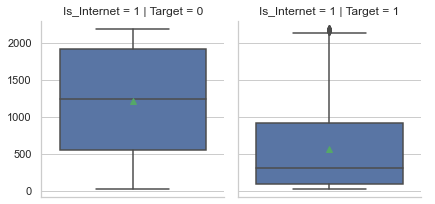

In [186]:
g = sns.FacetGrid(telecom[telecom['Is_Internet']==1], col="Target", row='Is_Internet', palette='Set2')#, hue='Target')
g.map_dataframe(sns.boxplot, y='ClientLifetime_D', showmeans=True)
g.add_legend()

In [187]:
telecom['ClientLifetime_D_q'] = pd.qcut(telecom[telecom['Is_Internet']==1]['ClientLifetime_D'],10)

In [188]:
t = telecom.groupby('ClientLifetime_D_q')[['Target']].agg(['count','mean'])
t.columns = ['_'.join(col).strip() for col in t.columns.values]
t

,Target_count,Target_mean
ClientLifetime_D_q,,
"(29.999, 61.0]",447,0.780761
"(61.0, 214.0]",469,0.524520
"(214.0, 395.0]",424,0.426887
"(395.0, 641.0]",449,0.354120
"(641.0, 914.0]",448,0.272321
"(914.0, 1248.0]",459,0.250545
"(1248.0, 1553.0]",399,0.230576
"(1553.0, 1857.0]",451,0.152993
"(1857.0, 2102.0]",431,0.116009


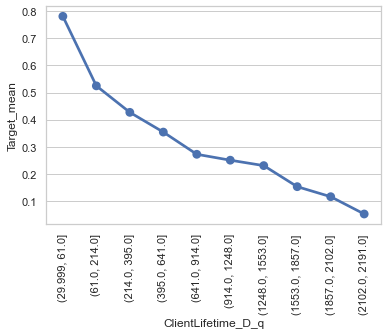

In [189]:
sns.pointplot(data = t, x=t.index, y='Target_mean')
degrees = 90
plt.xticks( rotation = degrees)
plt.show()

 Отмечаем, что признак ClientLifetime_D показывает сильную связь с целевым признаком и хорошо разделяет пользователей внутри группы "есть интернет". Далее проверим это более строго

/Users/x_ray_serg/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


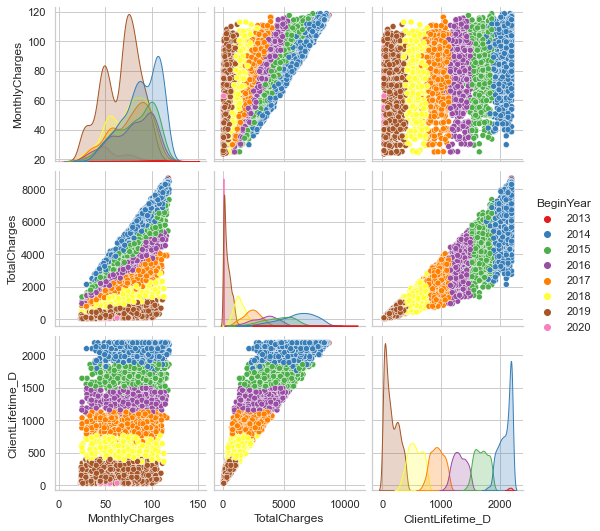

In [190]:
g = sns.pairplot(telecom.query('Is_Internet==1')[['MonthlyCharges','TotalCharges', 'ClientLifetime_D','BeginYear']],
                 hue = 'BeginYear', palette = 'Set1')#, y_vars="Target",
                 #x_vars=['Type','PaperlessBilling','PaymentMethod', 'gender'],
                 #height=4, aspect=0.8, hue='Is_Internet')


### 2.3 Статистические оценки взаимосвязи признаков с целевым признаком. Проверка мультиколлинеарности

Проверим взаимосвязь признаков с целелевым признаком с помощью стат. методов

#### Количественные признаки

Для количественных признаков будем использовать t- критерий Стьюдента
1. H0 - средние значение данного признака для отточников (Target =1)  и оставшихся (Target =0) одинаково
2. H1 - средние значения данного признака для отточников и оставшихся отличаются

В качестве уровня значимости возьмем 0.05

Для  проверки наших расчетов введем дополнительный числовой признак, принимающий случайные значения в интервале от 0 до 1

In [191]:
telecom['rand_int'] = np.random.rand(len(telecom))

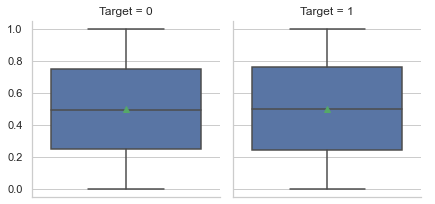

In [192]:
g = sns.FacetGrid(telecom, col="Target", palette='Set2')#, hue='Target')
g.map_dataframe(sns.boxplot, y='rand_int', showmeans=True)
g.add_legend()

In [193]:
telecom.groupby('Target')['rand_int'].mean()

Target
0    0.497673
1    0.496746
Name: rand_int, dtype: float64

Выполняем т-тест для всех числовых признаков признаков, в том числе для проверочного rand_int

In [194]:
columns_list = ['MonthlyCharges', 'TotalCharges', 'ClientLifetime_D', 'rand_int']

In [195]:
tt_value = []
p_value = []

for i in columns_list:
    tt_test = stats.ttest_ind(telecom[(telecom['Target']==0)][i], 
                              telecom[(telecom['Target']==1)][i], axis=0, equal_var=False)
    tt_value.append(tt_test[0])
    p_value.append(tt_test[1])
values = pd.DataFrame({'column': columns_list, 'tt_value':tt_value,  'p_value':p_value}).sort_values(by='p_value',
                                                                                                    ascending=False)
values['p_crit'] = 0.05

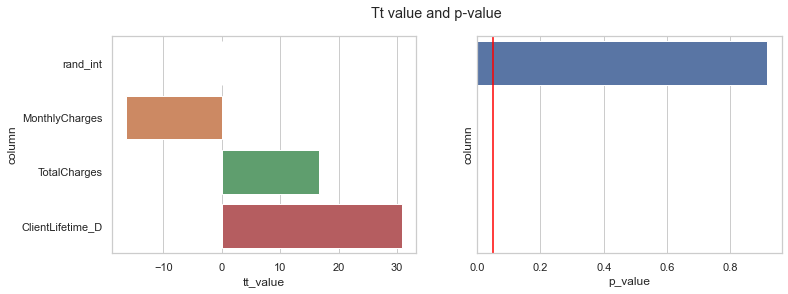

In [196]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,4))
fig.suptitle('Tt value and p-value')
sns.barplot(ax=ax[0], x='tt_value', y='column', data= values)
g=sns.barplot(ax=ax[1], x='p_value', y='column', data= values)
g.axvline(0.05, color='red')

С учетом принятого уровня значимости для всех признаков, кроме rand_int, нулевая гипотеза отклоняется

Оценим мультиколлинеарность числовых признаков

<AxesSubplot:>

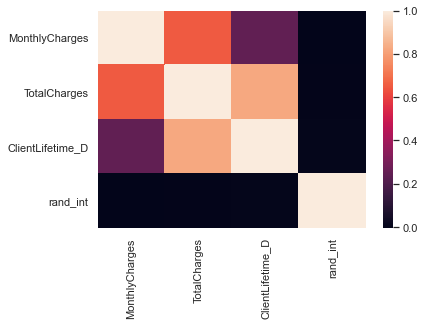

In [197]:
t = telecom[['MonthlyCharges','TotalCharges', 'ClientLifetime_D','rand_int']].corr()
sns.heatmap(t)

Признаки TotalCharges и ClientLifetime_D оказываются сильно скоррелироваными. При обучении моделей следует попробовать каждый из них и выбрать наилучший

In [198]:
num_features_stat_selected = ['MonthlyCharges', 'TotalCharges']
num_features_need_add = ['ClientLifetime_D']

#### Категориальные признаки

С помощью коэффициента Крамера оценим взаимосвязь целевого признака и каждого из категориальных

Аналогично rand_int cоздадим признак rand_bin, который содержит значения 0 и 1 в слуайном порядке

In [199]:
telecom['rand_bin'] = np.random.randint(2, size=len(telecom))

In [200]:
telecom.groupby('Target')['rand_bin'].mean()

Target
0    0.481114
1    0.494314
Name: rand_bin, dtype: float64

In [201]:
def cramers(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    p = chi2_contingency(confusion_matrix)[1]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return chi2, p, np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

Начнем с признаков для всех контрактов (Type, PaperlessBilling, PaymentMethod, gender, MultipleLines, SeniorCitizen,	Partner, Dependents)

<AxesSubplot:>

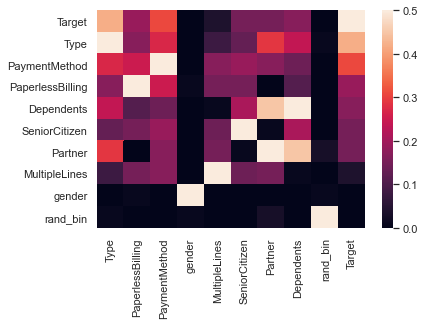

In [328]:
import numpy as np
column_list=['Type','PaperlessBilling','PaymentMethod', 'gender', 'MultipleLines', 'SeniorCitizen',	'Partner','Dependents', 'rand_bin', 'Target']
cramer_all_value = np.zeros([len(column_list), len(column_list)])
for i in range(len(column_list)):
    for j in range(len(column_list)):
        result = cramers(telecom[column_list[i]], telecom[column_list[j]])
        cramer_all_value[i,j]=round(result[2],2)

cramer_all_value = pd.DataFrame(cramer_all_value, columns = column_list, index = column_list )
sns.heatmap(cramer_all_value.sort_values(by='Target',ascending=False), vmax=0.5)

In [203]:
cramer_all_value['Target'].sort_values(ascending=False)

Target              1.00
Type                0.42
PaymentMethod       0.31
PaperlessBilling    0.19
Dependents          0.17
SeniorCitizen       0.15
Partner             0.15
MultipleLines       0.04
gender              0.00
rand_bin            0.00
Name: Target, dtype: float64

В дальнейшем анализе не будем рассматривать MultipleLines и gender

Перейдем к признакам для контрактов с интернетом (InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies)

<AxesSubplot:>

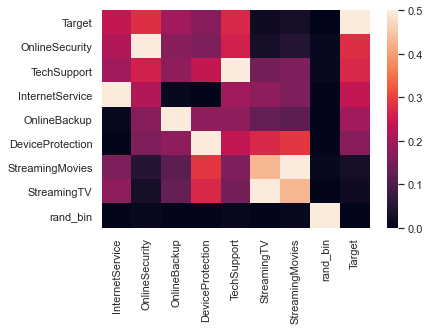

In [329]:
column_list=['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport', 'StreamingTV','StreamingMovies','rand_bin','Target']
cramer_all_value = np.zeros([len(column_list), len(column_list)])
for i in range(len(column_list)):
    for j in range(len(column_list)):
        result = cramers(telecom.query('Is_Internet==1')[column_list[i]], telecom.query('Is_Internet==1')[column_list[j]])
        cramer_all_value[i,j]=round(result[2],2)

cramer_all_value = pd.DataFrame(cramer_all_value, columns = column_list, index = column_list)
sns.heatmap(cramer_all_value.sort_values(by='Target',ascending=False), vmax=0.5)

In [205]:
cramer_all_value['Target'].sort_values(ascending=False)

Target              1.00
OnlineSecurity      0.28
TechSupport         0.27
InternetService     0.24
OnlineBackup        0.20
DeviceProtection    0.17
StreamingMovies     0.03
StreamingTV         0.02
rand_bin            0.00
Name: Target, dtype: float64

В дальнейшем анализе не будем рассматривать StreamingMovies и StreamingTV

In [206]:
cat_features_stat_selected = ['Type', 'PaymentMethod', 
                              'PaperlessBilling', 'Dependents', 'SeniorCitizen', 'Partner', 'OnlineSecurity', 'TechSupport',
                             'InternetService', 'OnlineBackup', 'DeviceProtection']

## 3. Подготовка данных для алгортимов машинного обучения

### 3.1 Выбор нужной части датасетов

In [207]:
date_features = ['EndDate', 'BeginDate']

In [208]:
features_selected = cat_features_stat_selected + num_features_stat_selected + date_features

В тренировочный и тестовый датасеты включим выбранные выше признаки. Кроме того, для автоматического создания в Pipeline признака ClientLifetime_D,  оставим в датасетах признаки EndDate и BeginDate. Перед обучением эти два признака будут удалены

In [209]:
X_train, X_test = X_train[features_selected], X_test[features_selected]

### 3.2 Создание и выбор новых признаков

In [211]:
class Choose_features(BaseEstimator, TransformerMixin):
    def __init__(self, lifetime=True):
    # Оставляем или ClientLifetime_D или ClientLifetime_M
        self.lifetime = lifetime
    def fit(self, X, y= None):
        return self
    def transform(self, X, y= None):
        df=pd.DataFrame(X).copy()    
        if self.lifetime: 
            df['ClientLifetime_D'] = round((df['EndDate'] - df['BeginDate'])/np.timedelta64(1,'D'),1)
            df = df.drop(['TotalCharges', 'BeginDate', 'EndDate'], axis=1)
        else: 
            df = df.drop(['BeginDate', 'EndDate'], axis=1)
        return df 

### 3.3 Обработка признаков

In [212]:
# Выполняем для того, чтобы после кодировки не оставались одинаковое столбцы , там где мы заполняли пропуски no_internet
class Prepare_columns(BaseEstimator, TransformerMixin):
    def __init__(self, prepare_columns=True):
        self.prepare_columns = prepare_columns
    def fit(self, X, y= None):
        return self
    def transform(self, X, y= None):
        df=pd.DataFrame(X).copy()
        if self.prepare_columns:
            df['no_internet'] = (df[list(set(data_internet.columns.tolist()) & set(features_selected))[1]] == 'no_internet')*1
            df = df.replace(['Yes', 'No', 'no_internet'],[1, 0, 0])
            df = df.replace(['Fiber optic', 'DSL'],[1, 0])
        return df

In [213]:
cat_transformer = Pipeline([('onehot', OneHotEncoder(drop='first'))])
num_transformer = Pipeline([('scaler', StandardScaler())])

In [214]:
col_transform = ColumnTransformer([
        ('cat', cat_transformer, make_column_selector(dtype_include=object)),
        ('num', num_transformer, make_column_selector(dtype_include=np.number))])

In [215]:
preprocessor = Pipeline([('Prepare', Prepare_columns()),
                         ('Choose', Choose_features()),
                          ('Transform', col_transform)])

## 4. Выбор, обучение и точная настройка моделей

### 4.1 Baseline

In [216]:
y_pred_2 = (np.random.rand(len(X_test)))
roc_auc_2  = roc_auc_score(y_test, y_pred_2)
round(roc_auc_2,3)

0.502

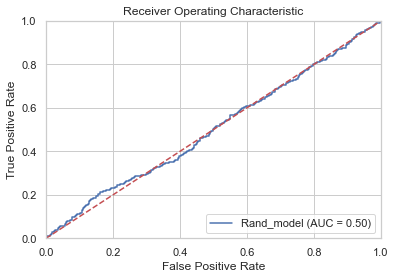

In [217]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_2)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Rand_model (AUC = %0.2f)' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### 4.2 Логистическая регрессия

In [218]:
lr = Pipeline([('prep', preprocessor),
            ('clf', LogisticRegression())])

In [219]:
param_grid_lr = {
    "prep__Choose__lifetime": [True, False],
    "clf__C": [0.1, 1.0, 10]}

In [220]:
kfolds = StratifiedKFold(5, shuffle=True, random_state =10)

In [221]:
grid_search_lr = GridSearchCV(lr, param_grid_lr,scoring='roc_auc', cv=kfolds.split(X_train, y_train))

In [222]:
grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fde5d1b6350>,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('Prepare',
                                                         Prepare_columns()),
                                                        ('Choose',
                                                         Choose_features()),
                                                        ('Transform',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehot',
                                                                                                           OneHotEncoder(drop='first'))]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fde4a0ed460>),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fde4a0ed970>)]))])),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.1, 1.0, 10],
                         'prep__Choose__lifetime': [True, False]},
             scoring='roc_auc')

In [223]:
round(grid_search_lr.best_score_,3)

0.842

In [224]:
grid_search_lr.best_params_

{'clf__C': 10, 'prep__Choose__lifetime': True}

In [225]:
cv_results_lr = pd.DataFrame(grid_search_lr.cv_results_)
cv_results_lr[["mean_test_score", 'param_clf__C', 'param_prep__Choose__lifetime']].sort_values(by='mean_test_score', ascending = False).head(10)

,mean_test_score,param_clf__C,param_prep__Choose__lifetime
4,0.842329,10,True
2,0.842321,1.0,True
0,0.841822,0.1,True
3,0.837717,1.0,False
5,0.837669,10,False
1,0.837254,0.1,False


In [226]:
round(grid_search_lr.score(X_train, y_train),3)

0.845

In [227]:
grid_search_lr.best_estimator_.named_steps['prep']['Transform'].get_feature_names_out()

array(['cat__Type_One year', 'cat__Type_Two year',
       'cat__PaymentMethod_Credit card (automatic)',
       'cat__PaymentMethod_Electronic check',
       'cat__PaymentMethod_Mailed check', 'num__PaperlessBilling',
       'num__Dependents', 'num__SeniorCitizen', 'num__Partner',
       'num__OnlineSecurity', 'num__TechSupport', 'num__InternetService',
       'num__OnlineBackup', 'num__DeviceProtection',
       'num__MonthlyCharges', 'num__no_internet', 'num__ClientLifetime_D'],
      dtype=object)

### 4.3 Случайный лес

In [228]:
rf = Pipeline([('prep', preprocessor),
            ('clf', RandomForestClassifier(random_state=42))])

In [229]:
param_grid_rf = {
    "prep__Choose__lifetime": [True, False],
    'clf__max_depth': [3, 4, 5, 6],
    'clf__n_estimators': [50, 70, 90, 110]
}

In [230]:
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring='roc_auc', cv=kfolds.split(X_train, y_train))

In [231]:
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fde5d16dac0>,
             estimator=Pipeline(steps=[('prep',
                                        Pipeline(steps=[('Prepare',
                                                         Prepare_columns()),
                                                        ('Choose',
                                                         Choose_features()),
                                                        ('Transform',
                                                         ColumnTransformer(transformers=[('cat',
                                                                                          Pipeline(steps=[('onehot',
                                                                                                           OneHotEncoder(drop='first'))]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fde4a0ed460>),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           StandardScaler())]),
                                                                                          <sklearn.compose._column_transformer.make_column_selector object at 0x7fde4a0ed970>)]))])),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'clf__max_depth': [3, 4, 5, 6],
                         'clf__n_estimators': [50, 70, 90, 110],
                         'prep__Choose__lifetime': [True, False]},
             scoring='roc_auc')

In [232]:
round(grid_search_rf.best_score_,3)

0.859

In [233]:
grid_search_rf.best_params_

{'clf__max_depth': 6, 'clf__n_estimators': 90, 'prep__Choose__lifetime': True}

In [234]:
cv_results_rf = pd.DataFrame(grid_search_rf.cv_results_)
cv_results_rf[["mean_test_score", 'param_clf__max_depth', 'param_clf__n_estimators',
               'param_prep__Choose__lifetime']].sort_values(by='mean_test_score', ascending = False).head(10)

,mean_test_score,param_clf__max_depth,param_clf__n_estimators,param_prep__Choose__lifetime
28,0.859385,6,90,True
30,0.859262,6,110,True
26,0.858964,6,70,True
24,0.858622,6,50,True
22,0.857091,5,110,True
20,0.856968,5,90,True
16,0.856887,5,50,True
18,0.856853,5,70,True
14,0.854603,4,110,True
12,0.854531,4,90,True


In [235]:
round(grid_search_rf.score(X_train, y_train),3)

0.88

### 4.4 Catboost

Разделим предобработку и обучение модели. Исходя из опыта обучения логистической регрессии и случайного леса, выберем оптимальные параметры предобработки

In [236]:
preprocessor_cat = Pipeline([
                         ('Choose', Choose_features())])

In [237]:
X_train_cb, X_test_cb = preprocessor_cat.transform(X_train), preprocessor_cat.transform(X_test)
X_test_cb

,Type,PaymentMethod,PaperlessBilling,Dependents,SeniorCitizen,Partner,OnlineSecurity,TechSupport,InternetService,OnlineBackup,DeviceProtection,MonthlyCharges,ClientLifetime_D
971,Two year,Credit card (automatic),Yes,Yes,0,Yes,No,Yes,DSL,Yes,No,75.95,1798.0
618,Month-to-month,Bank transfer (automatic),Yes,No,0,No,No,No,Fiber optic,Yes,No,78.55,215.0
4282,Two year,Mailed check,No,No,0,No,no_internet,no_internet,no_internet,no_internet,no_internet,20.10,1645.0
3715,Month-to-month,Mailed check,No,No,0,No,no_internet,no_internet,no_internet,no_internet,no_internet,20.65,61.0
4525,Two year,Bank transfer (automatic),Yes,No,0,Yes,No,No,Fiber optic,Yes,Yes,105.15,2163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4821,Month-to-month,Bank transfer (automatic),Yes,No,0,No,No,No,DSL,No,No,45.00,365.0
5168,Month-to-month,Mailed check,No,Yes,0,No,Yes,Yes,DSL,No,No,45.80,792.0
2745,One year,Mailed check,Yes,No,0,No,no_internet,no_internet,no_internet,no_internet,no_internet,19.45,92.0
4424,Two year,Mailed check,Yes,No,0,No,Yes,Yes,DSL,Yes,No,40.55,1126.0


In [238]:
train_pool = Pool(data=X_train_cb, label=y_train, cat_features = 
                  X_train_cb.select_dtypes(include=['object']).columns.tolist())

In [239]:
model_cb =  CatBoostClassifier(eval_metric='AUC', loss_function = 'Logloss', verbose= False)

In [240]:
grid= {'learning_rate': [0.03, 0.1],
        'depth': [4, 8]}

In [241]:
grid_search_cb = model_cb.grid_search(grid, train_pool, partition_random_seed=42, 
                                      search_by_train_test_split = False, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8981674184
bestIteration = 999

Training on fold [1/5]

bestTest = 0.9019006049
bestIteration = 998

Training on fold [2/5]

bestTest = 0.8973555921
bestIteration = 998

Training on fold [3/5]

bestTest = 0.8980540462
bestIteration = 997

Training on fold [4/5]

bestTest = 0.9131325565
bestIteration = 999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.9017148	best: 0.9017148 (0)	total: 19.5s	remaining: 58.4s
Training on fold [0/5]

bestTest = 0.9234372849
bestIteration = 995

Training on fold [1/5]

bestTest = 0.9272939662
bestIteration = 997

Training on fold [2/5]

bestTest = 0.9268101096
bestIteration = 992

Training on fold [3/5]

bestTest = 0.9278304599
bestIteration = 990

Training on fold [4/5]

bestTest = 0.9299966798
bestIteration = 997

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~f

In [242]:
grid_search_data = pd.DataFrame(grid_search_cb['cv_results'])

In [243]:
round(grid_search_data['test-AUC-mean'].max(),3)

0.927

In [244]:
best_iter = grid_search_data[grid_search_data['test-AUC-mean'] 
                             == grid_search_data['test-AUC-mean'].max()]['iterations'].values[0]
best_iter

996

In [245]:
grid_search_cb['params']

{'depth': 4, 'learning_rate': 0.1}

In [246]:
print(f"Tree count: {str(model_cb.tree_count_)}")

Tree count: 1000


In [247]:
round(roc_auc_score(y_train, pd.DataFrame(model_cb.predict_proba(X_train_cb))[1]),3)

0.97

### 4.5 Сравнение моделей

#### ROC AUC

In [255]:
fpr_lr, tpr_lr, threshold = metrics.roc_curve(y_train, pd.DataFrame(grid_search_lr.predict_proba(X_train))[1])
roc_auc_lr = round(metrics.auc(fpr_lr, tpr_lr),3)

In [256]:
fpr_rf, tpr_rf, threshold = metrics.roc_curve(y_train, pd.DataFrame(grid_search_rf.predict_proba(X_train))[1])
roc_auc_rf = round(metrics.auc(fpr_rf, tpr_rf),3)

In [257]:
fpr_cb, tpr_cb, threshold = metrics.roc_curve(y_train, pd.DataFrame(model_cb.predict_proba(X_train_cb))[1])
roc_auc_cb = round(metrics.auc(fpr_cb, tpr_cb),3)

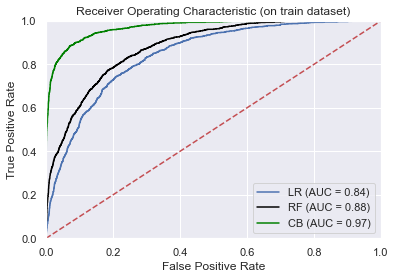

In [258]:
plt.title('Receiver Operating Characteristic (on train dataset)')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'LR (AUC = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'black', label = 'RF (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_cb, tpr_cb, 'green', label = 'CB (AUC = %0.2f)' % roc_auc_cb)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
sns.set(font_scale = 1)

На кроссвалидации лучше всего себя показала модель Catboost

#### Feature importance

##### LR and RF

In [259]:
feature_importance = pd.DataFrame(abs(grid_search_lr.best_estimator_.named_steps["clf"].coef_[0]),
                                     index =  grid_search_lr.best_estimator_.named_steps['prep']['Transform'].get_feature_names_out(),
                                     columns = ['Importance']).reset_index()

feature_importance['Type_of_model'] = 'LR'

In [260]:
feature_importance_rf = pd.DataFrame(grid_search_rf.best_estimator_.named_steps["clf"].feature_importances_,
                                     index =  grid_search_rf.best_estimator_.named_steps["prep"]['Transform'].get_feature_names_out(),
                                     columns = ['Importance']).reset_index()

feature_importance_rf['Type_of_model'] = 'RF'


In [261]:
feature_importance = feature_importance.append(feature_importance_rf)

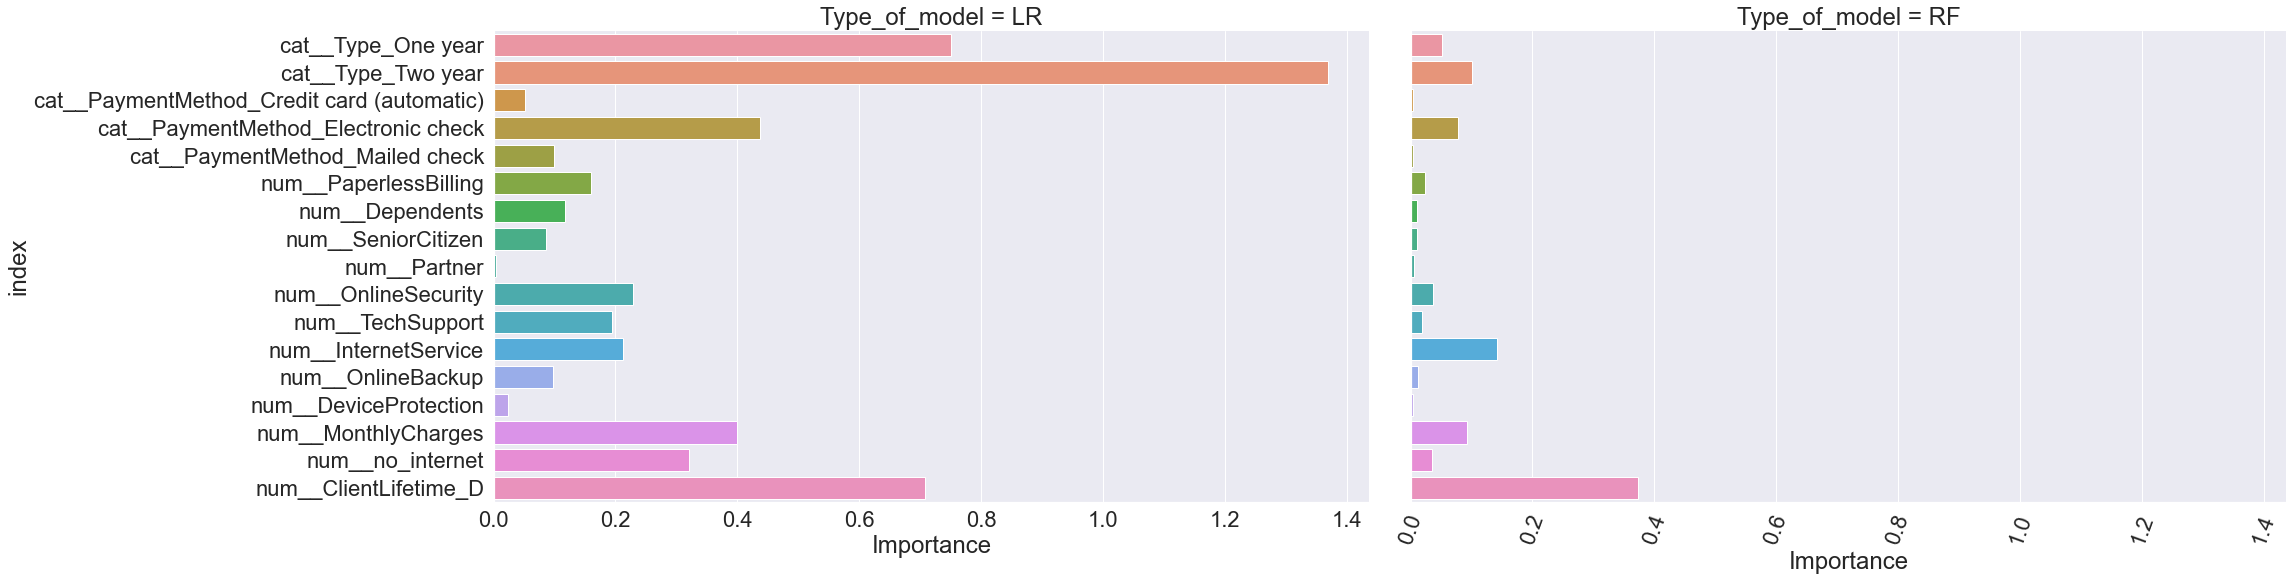

In [316]:
sns.catplot(x="Importance", y="index", col="Type_of_model", kind="bar", 
            height=8, aspect=2, data=feature_importance)
degrees = 70
plt.xticks(rotation = degrees)
sns.set(font_scale = 3)

##### Catboost

In [263]:
feature_importance_cb = model_cb.get_feature_importance(prettified=True)

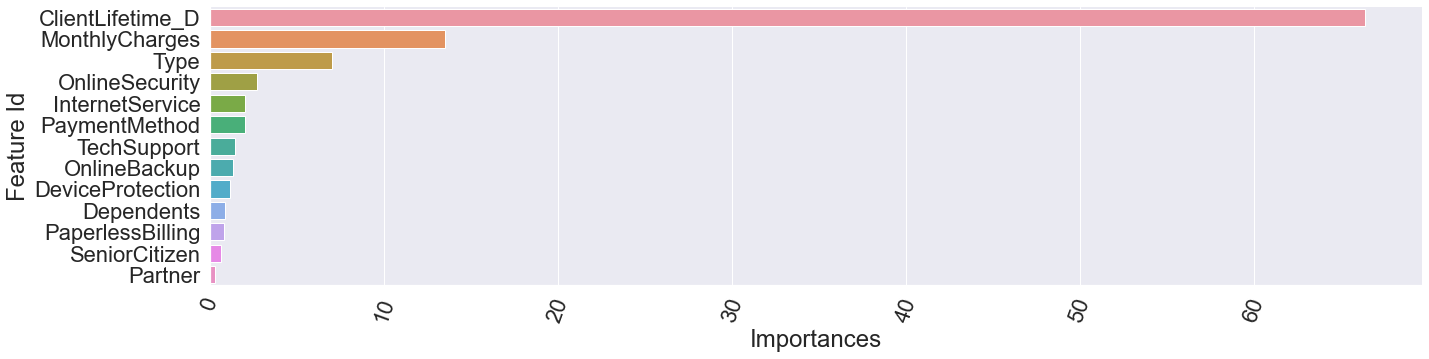

In [285]:
sns.catplot(y="Feature Id", x="Importances", kind="bar", 
            height=5, aspect=4, data=feature_importance_cb)
degrees = 70
plt.xticks(rotation = degrees)
sns.set(font_scale = 1)

## 5. Проверка моделей на тестовой выборке

In [267]:
final_predictions_lr = grid_search_lr.predict_proba(X_test)[:,1]
roc_auc_lr_test_all_f = round(roc_auc_score(y_test, final_predictions_lr),3)

In [268]:
final_predictions_rf = grid_search_rf.predict_proba(X_test)[:,1]
roc_auc_rf_test_all_f = round(roc_auc_score(y_test, final_predictions_rf),3)

In [269]:
test_pool = Pool(data=X_test_cb, label=y_test, cat_features = 
                  X_test_cb.select_dtypes(include=['object']).columns.tolist())

In [270]:
final_predictions_cb = model_cb.predict_proba(test_pool)[:,1]
roc_auc_cb_test_all_f = round(roc_auc_score(y_test, final_predictions_cb),3)

In [271]:
results = pd.DataFrame([[preprocessor.fit_transform(X_train).shape[1], roc_auc_lr, roc_auc_lr_test_all_f],
                        [preprocessor.fit_transform(X_train).shape[1], roc_auc_rf, roc_auc_rf_test_all_f],
                        [len(X_train_cb.columns), roc_auc_cb, roc_auc_cb_test_all_f]],
                        index=pd.Index(['LR', 'RF', 'CB']), 
                       columns=pd.MultiIndex.from_product([['All features (after EDA & preprocessing)'],['N_of_features', 'Train_score', 'Test_score']]))

results

All features (after EDA & preprocessing)                       
                              N_of_features Train_score Test_score
LR                                       17       0.845      0.833
RF                                       17       0.880      0.852
CB                                       13       0.970      0.927

In [227]:
grid_search_lr.best_estimator_.named_steps['prep']['Transform'].get_feature_names_out()

array(['cat__Type_One year', 'cat__Type_Two year',
       'cat__PaymentMethod_Credit card (automatic)',
       'cat__PaymentMethod_Electronic check',
       'cat__PaymentMethod_Mailed check', 'num__PaperlessBilling',
       'num__Dependents', 'num__SeniorCitizen', 'num__Partner',
       'num__OnlineSecurity', 'num__TechSupport', 'num__InternetService',
       'num__OnlineBackup', 'num__DeviceProtection',
       'num__MonthlyCharges', 'num__no_internet', 'num__ClientLifetime_D'],
      dtype=object)

In [227]:
grid_search_lr.best_estimator_.named_steps['prep']['Transform'].get_feature_names_out()

array(['cat__Type_One year', 'cat__Type_Two year',
       'cat__PaymentMethod_Credit card (automatic)',
       'cat__PaymentMethod_Electronic check',
       'cat__PaymentMethod_Mailed check', 'num__PaperlessBilling',
       'num__Dependents', 'num__SeniorCitizen', 'num__Partner',
       'num__OnlineSecurity', 'num__TechSupport', 'num__InternetService',
       'num__OnlineBackup', 'num__DeviceProtection',
       'num__MonthlyCharges', 'num__no_internet', 'num__ClientLifetime_D'],
      dtype=object)

И на тренировочной, и на тестовой выборке лучше всего себя показала модель Catboost. Однако, эта же модель оказалась наиболее склонной к переобучению

## 6. Оптимальное кол-во фичей

Проверим, можно ли добиться тех же значений метрики ROC AUC, при использовании меньшего количества признаков

In [272]:
X_train_prepare  = pd.DataFrame(preprocessor.fit_transform(X_train), columns = col_transform.get_feature_names_out())

In [273]:
X_test_prepare = pd.DataFrame(preprocessor.transform(X_test), columns = col_transform.get_feature_names_out())

### 6.1 LR


In [274]:
important_features_lr = feature_importance.query('Type_of_model=="LR"').sort_values(by='Importance', ascending=False)['index'].tolist()

In [305]:
def fitting_and_predict (model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    predictions_tr =  model.predict_proba(X_tr)[:,1]
    predictions_te = model.predict_proba(X_te)[:,1]
    return  round(roc_auc_score(y_tr, predictions_tr),3), round(roc_auc_score(y_te, predictions_te),3)

In [306]:
features_for_learn_lr = []
num_of_features_lr=[]
roc_auc_lr_train = []
roc_auc_lr_test = []

model_lr = LogisticRegression(C=1)
for feature in important_features_lr:
    features_for_learn_lr.append(feature)
    num_of_features_lr.append(len(features_for_learn_lr))
    scores = fitting_and_predict (model_lr, X_train_prepare[features_for_learn_lr], y_train, X_test_prepare[features_for_learn_lr], y_test)
    roc_auc_lr_train.append(scores[0])
    roc_auc_lr_test.append(scores[1])
 

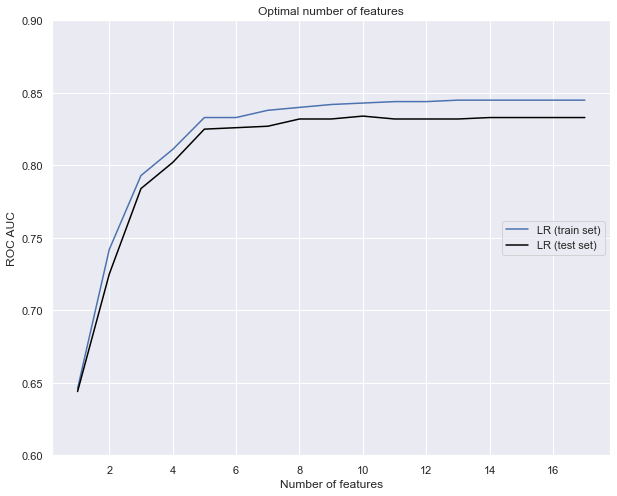

In [307]:
plt.figure(figsize=(10,8))
plt.title('Optimal number of features')
plt.plot(num_of_features_lr, roc_auc_lr_train, 'b', label = 'LR (train set)')
plt.plot(num_of_features_lr, roc_auc_lr_test, 'black', label = 'LR (test set)')
plt.legend(loc = 'center right')
plt.ylim([0.6, 0.9])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()
sns.set(font_scale = 1)

In [287]:
num_of_features_lr_opt = 10
important_features_lr[0:10]

['cat__Type_Two year',
 'cat__Type_One year',
 'num__ClientLifetime_D',
 'cat__PaymentMethod_Electronic check',
 'num__MonthlyCharges',
 'num__no_internet',
 'num__OnlineSecurity',
 'num__InternetService',
 'num__TechSupport',
 'num__PaperlessBilling']

In [308]:
roc_auc_lr_train[9]

0.843

In [309]:
roc_auc_lr_test[9]

0.834

 Для модели логистической регрессии достаточно 10 признаков (из изначальных 17)

### 6.2 RF

In [310]:
important_features_rf = feature_importance.query('Type_of_model=="RF"').sort_values(by='Importance', ascending=False)['index'].tolist()

In [312]:
features_for_learn_rf = []
num_of_features_rf=[]
roc_auc_rf_train = []
roc_auc_rf_test = []

model_rf = RandomForestClassifier(max_depth=6, n_estimators = 110, random_state=42)
for feature in important_features_rf:
    features_for_learn_rf.append(feature)
    num_of_features_rf.append(len(features_for_learn_rf))
    scores = fitting_and_predict (model_rf, X_train_prepare[features_for_learn_rf], y_train, X_test_prepare[features_for_learn_rf], y_test)
    roc_auc_rf_train.append(scores[0])
    roc_auc_rf_test.append(scores[1])

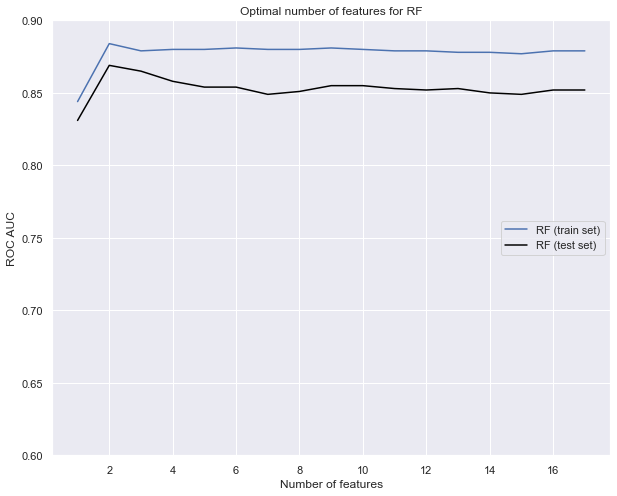

In [313]:
plt.figure(figsize=(10,8))
plt.title('Optimal number of features for RF')
plt.plot(num_of_features_rf, roc_auc_rf_train, 'b', label = 'RF (train set)')
plt.plot(num_of_features_rf, roc_auc_rf_test, 'black', label = 'RF (test set)')
plt.legend(loc = 'center right')
plt.ylim([0.6, 0.9])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features')
plt.show()
sns.set(font_scale = 1)

In [317]:
num_of_features_rf_opt = 5
important_features_rf[0:5]

['num__ClientLifetime_D',
 'num__InternetService',
 'cat__Type_Two year',
 'num__MonthlyCharges',
 'cat__PaymentMethod_Electronic check']

In [318]:
roc_auc_rf_train[4]

0.88

In [319]:
roc_auc_rf_test[4]

0.854

In [ ]:
Для модели случайного леса достаточно 5 признаков (из изначальных 17)

### 6.3 Catboost

In [320]:
important_features_cb = model_cb.get_feature_importance(prettified=True)['Feature Id'].tolist()
important_features_cb

['ClientLifetime_D',
 'MonthlyCharges',
 'Type',
 'PaymentMethod',
 'OnlineSecurity',
 'InternetService',
 'TechSupport',
 'OnlineBackup',
 'DeviceProtection',
 'PaperlessBilling',
 'Dependents',
 'SeniorCitizen',
 'Partner']

In [321]:
features_for_learn_cb = []
num_of_features_cb=[]
roc_auc_cb_train = []
roc_auc_cb_test = []

test_pool = Pool(data=X_test_cb, label=y_test, cat_features = 
                  X_test_cb.select_dtypes(include=['object']).columns.tolist())

for feature in important_features_cb:
    features_for_learn_cb.append(feature)
    num_of_features_cb.append(len(features_for_learn_cb))

    train_pool = Pool(data=X_train_cb[features_for_learn_cb], label=y_train, cat_features = 
                  X_train_cb[features_for_learn_cb].select_dtypes(include=['object']).columns.tolist())

    test_pool = Pool(data=X_test_cb[features_for_learn_cb], label=y_test, cat_features = 
                  X_test_cb[features_for_learn_cb].select_dtypes(include=['object']).columns.tolist())

    model_cb.fit(train_pool)
    roc_auc_cb_train.append(round(roc_auc_score(y_train,model_cb.predict_proba(train_pool)[:,1]),3))
    roc_auc_cb_test.append(round(roc_auc_score(y_test,model_cb.predict_proba(test_pool)[:,1]),3))

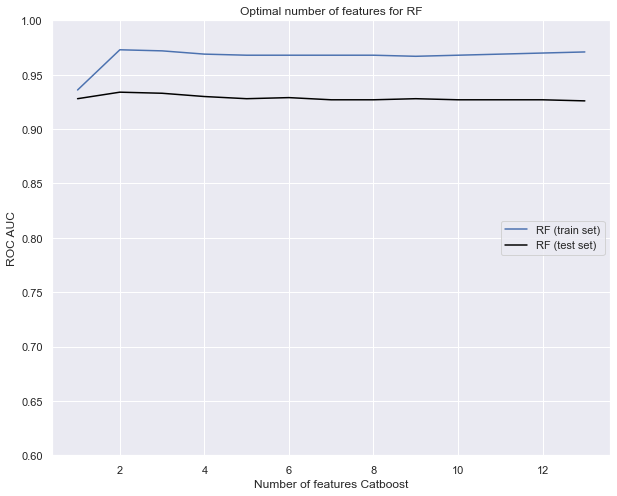

In [323]:
plt.figure(figsize=(10,8))
plt.title('Optimal number of features for RF')
plt.plot(num_of_features_cb, roc_auc_cb_train, 'b', label = 'RF (train set)')
plt.plot(num_of_features_cb, roc_auc_cb_test, 'black', label = 'RF (test set)')
plt.legend(loc = 'center right')
plt.ylim([0.6, 1])
plt.ylabel('ROC AUC')
plt.xlabel('Number of features Catboost')
plt.show()
sns.set(font_scale = 1)

In [324]:
num_of_features_cb_opt = 2
important_features_cb[0:2]

['ClientLifetime_D', 'MonthlyCharges']

In [325]:
roc_auc_cb_train[1]

0.973

In [326]:
roc_auc_cb_test[1]

0.934

Для модели Catboost достаточно 2 признаков (из изначальных 13)

In [327]:
optimum_result = pd.DataFrame([[num_of_features_lr_opt, roc_auc_lr_train[num_of_features_lr_opt-1], roc_auc_lr_test[num_of_features_lr_opt-1]],
                        [num_of_features_rf_opt, roc_auc_rf_train[num_of_features_rf_opt-1], roc_auc_rf_test[num_of_features_lr_opt-1]],
                        [num_of_features_cb_opt, roc_auc_cb_train[num_of_features_cb_opt-1], roc_auc_cb_test[num_of_features_lr_opt-1]]],
                        index=pd.Index(['LR', 'RF', 'CB']), 
                       columns=pd.MultiIndex.from_product([['Optimum number of features'],['N_of_features', 'Train_score', 'Test_score']]))

optimum_result

Optimum number of features                       
                N_of_features Train_score Test_score
LR                         10       0.843      0.834
RF                          5       0.880      0.855
CB                          2       0.973      0.927

## 7.  Анализ результатов

Интегральные результаты проведенного анализа и прогнозирования приведены в таблице ниже. Наилучшие результаты получены на базе модели Catboost. Для обучения достаточно всего двух признаков: ClientLifetime_D, MonthlyCharges


In [304]:
final =  results.join(optimum_result)
final

All features (after EDA & preprocessing)                         \
                              N_of_features Train_score Test_score   
LR                                       17       0.845      0.833   
RF                                       17       0.880      0.852   
CB                                       13       0.970      0.927   

   Optimum number of features                         
                N_of_features Train_score Test_score  
LR                         10       0.843      0.834  
RF                          5       0.880      0.855  
CB                          2       0.973      0.923